In [31]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from h3 import h3
from geopy.geocoders import Nominatim
from geopy.distance import distance
import callmap 
import matplotlib.pyplot as plt 
%matplotlib inline 
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 50
import seaborn  as sns 
import lightgbm as lgb
import matplotlib.style as stl 
stl.use('fivethirtyeight')

%matplotlib inline

from itertools import product

import gc 
gc.collect()


# custom validation module 
from validation import TimeSeriesKFold, split_train_test
from pandas_profiling import  ProfileReport

In [3]:
# load data
df = pd.read_csv('../data/data_hackathon_v04.csv', sep='|')

# Simple Data Exploration 

In [4]:
pp = ProfileReport(df)
pp.to_file(outputfile="report.html")

In [5]:
pp

Number of variables,12
Number of observations,1117300
Total Missing (%),0.9%
Total size in memory,102.3 MiB
Average record size in memory,96.0 B
Numeric,5
Categorical,3
Boolean,3
Date,0
Text (Unique),1
Rejected,0


In [6]:
df.created_at.min(), df.created_at.max()

('2018-08-21 00:00:03.803000000', '2019-02-21 15:59:53.877000000')

In [7]:
# prepare geo data

geo_data = df.sample(1000)

data = np.hstack(
    [
        geo_data[['pickup_lat', 'pickup_lng']].values, # coordinates
        np.ones((geo_data.shape[0], 1)) # point intensity
    ]
).tolist()


m = folium.Map(location=[49.837013, 24.034357], tiles='OpenStreetMap', zoom_start=12)
HeatMap(data, blur=2, radius=3).add_to(m)
m

# Clustering 

## Method1 . Simple Hexagons 
## Looks like the most easiest way  - why not to try ? 
### devide geospational data to same size  hexagons  

In [8]:
def generate_hexagon_clusters(df, lat_col, long_col, coeff=8, save=False, save_path='cells.html'):
    clusters = df.apply(lambda x: h3.geo_to_h3(x[lat_col],x[long_col], coeff), axis='columns')
    m = folium.Map([0, 0], tiles='OpenStreetMap', zoom_start=1)
    for h3_address in list(clusters.unique()):
        boundary = h3.h3_to_geo_boundary(h3_address)
        boundary.append(boundary[0])
        folium.PolyLine(boundary).add_to(m)
    if save:   
        m.save(save_path)
    return clusters

In [93]:
coefficient = 9

In [94]:
df['pickup_cell'] = generate_hexagon_clusters(
    df, 
    lat_col='pickup_lat', 
    long_col='pickup_lng', 
    coeff=coefficient,
    save=True,
    save_path='cells.html'
)

df['dropoff_cell'] = generate_hexagon_clusters(
    df, 
    lat_col='dropoff_lat', 
    long_col='dropoff_lng', 
    coeff=coefficient, 
)

In [95]:
df['pickup_cell'].nunique()

2286

In [96]:
# bomj-style vizualization 
def vizualize(df, cluster_col, long_col, lat_col):
    mapping = dict(zip(
        df[cluster_col].unique(), 
        np.arange(df[cluster_col].nunique())
    ))
    clusters = df[cluster_col].map(mapping)
    plt.figure(figsize=(10,6))
    plt.title('Cluster labels visualization')
    plt.scatter(
        x=df[long_col],
        y=df[lat_col],
        c=clusters,
        cmap='rainbow',
        alpha=0.9,
        s=5,
    )

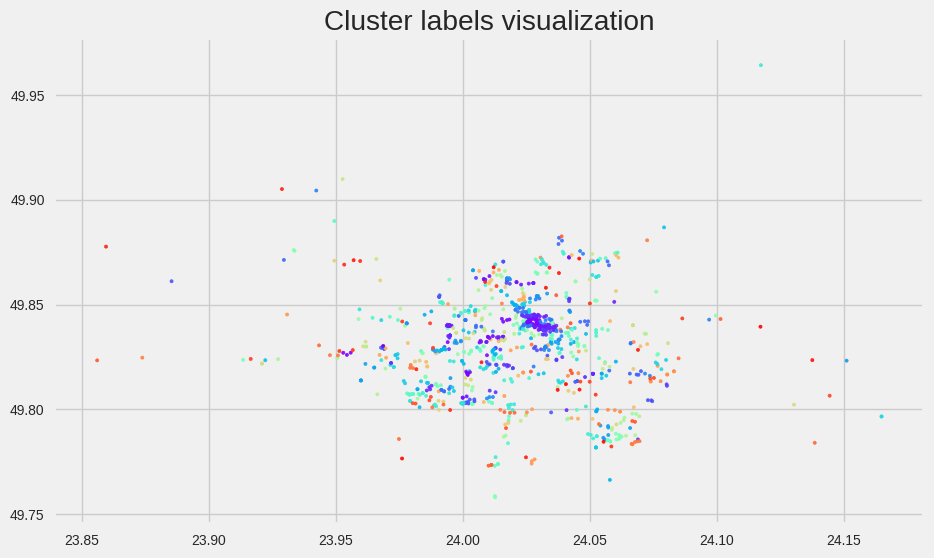

In [98]:
# simple for fast-checking vizualization in process of training models and tunning parameters 
vizualize(df.sample(1000), 'pickup_cell', 'pickup_lng', 'pickup_lat')

In [99]:
#how the rides are concentrated base on clustering 
from folium.plugins import MarkerCluster
import colorsys

In [100]:
def add_folium_clusters(m, df, cluster_col, long_col='Longitude', lat_col='Latitude'):
    mapping = dict(zip(
        df[cluster_col].unique(), 
        np.arange(df[cluster_col].nunique())
    ))
    clusters = df[cluster_col].map(mapping)
    N = df[cluster_col].nunique()
    HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]

    cluster_id2color = dict(zip(
        np.arange(df[cluster_col].nunique()), 
        HSV_tuples 
    ))

    for i in range(len(df)):
        lat = df[lat_col].values[i]
        long = df[long_col].values[i]
        
        cluster_id = clusters.iloc[i]
        color = cluster_id2color[cluster_id]
#         print(color, cluster_id)
        folium.Marker(
            location=[lat, long],
            popup='Location_' + str(clusters.iloc[i]),
            icon=folium.Icon(color=color)
        ).add_to(m)
    return m 

In [116]:
# initialize a folium geo map with a center location in random point at Lviv
m = folium.Map(location=[49.837013, 24.034357], tiles='OpenStreetMap', zoom_start=14)

In [107]:
df.head(2)

,ride_id,created_at,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,user_id,driver_id,ride_distance,canceled_by_client,canceled_by_driver,ride_to_suburb,pickup_cell,dropoff_cell,year,month,week
0,000002b3a3014388a6c62fdda1d03de1n,2018-12-14 23:00:00.043,49.824671,24.013246,49.784729,24.060303,3900450045004500300042003700310037003800460031...,a429c637c1244bb7a1d606d2b9987bdd,7.97,0,0,0,891e7689c77ffff,891e7613597ffff,2018,12,50
1,000013de085e4be4a2cd27d9112f7bdbn,2018-10-13 23:59:00.580,49.837906,24.029772,49.841217,23.974363,6227785C7862375C7863623F5C7866652E285F2D5C7861...,NaN,5.62,1,0,0,891e7688363ffff,891e7689197ffff,2018,10,41


In [117]:
# check rand  cluster 
c_id = df['pickup_cell'].iloc[0]

# lets add  data points from  one cluster  to  the map  for checking  / usage in  clustering exploration 
m = add_folium_clusters(
    m,  
    df[df['pickup_cell'] == c_id].sample(100), 
    'pickup_cell', 
    long_col='pickup_lng', 
    lat_col='pickup_lat'
)

In [118]:
m 

In [8]:
date_col = 'created_at'
df[date_col] = pd.to_datetime(df['created_at']).dt.floor('h') 

# Method 2. Classic technics   (of the basic clustering
)

Ideas : 
<br>simplier approaches (say, PCA + K-means) and 
<br> something tricky like UMAP / TSNE + DBSCAN / HDBSCAN

In [47]:
# let's cluster this data and see how it correlates with what we see
from sklearn.cluster import DBSCAN


# max distance between two points in one cluster
cell_constraint = 2 

db = DBSCAN(
    eps=cell_constraint/6371., 
    min_samples=10, 
    algorithm='ball_tree',
    metric='haversine'
)

#  reference : https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [49]:
# use two  whole weeks from data  to clustering based on denand with  constraints 
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month
df['week'] = df['created_at'].dt.week

In [57]:
sub_df = df[(df['year'] == 2019 ) 
            & (df['month'] == 2)
            & (df['week'] == 8)
           ]

data = sub_df[[
    'pickup_lat', 
    'pickup_lng'
]]
data.columns = ['Latitude', 'Longitude']
data['Latitude'] = data['Latitude'] 
data['Longitude'] = data['Longitude'] 

In [58]:
#  extract clusters 
cluster_labels = db.fit_predict(data[['Latitude', 'Longitude']].values)

In [69]:
# check statistics
print('Clusters found: {}'.format(np.unique(cluster_labels).shape[0]))
pd.Series(cluster_labels).value_counts()[1:].head(16)

Clusters found: 289


17     483
2      123
60     103
6       93
4       86
16      81
95      78
70      77
132     76
53      59
84      58
117     58
59      57
109     56
50      54
25      54
dtype: int64

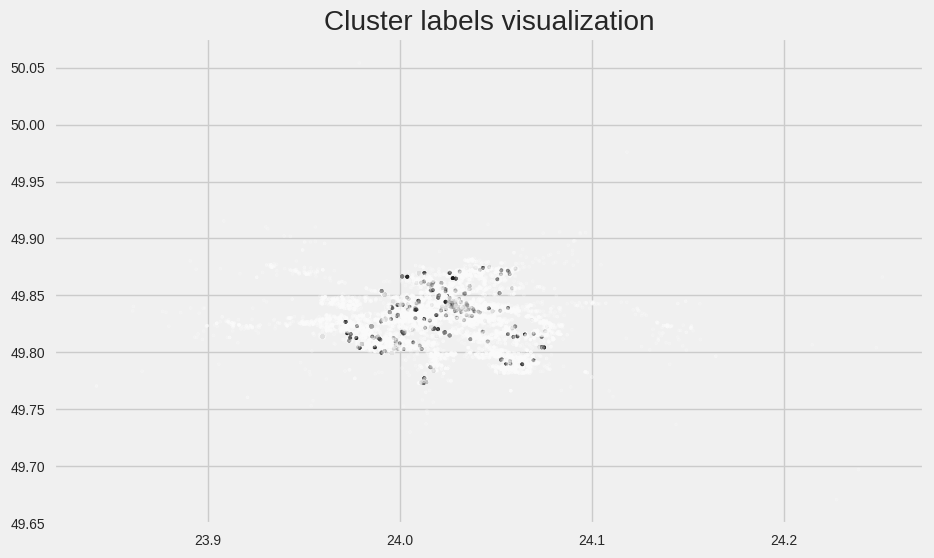

In [64]:
# visualize cluster labels
plt.figure(figsize=(10,6))
plt.title('Cluster labels visualization')
plt.scatter(
    x=data['Longitude'],
    y=data['Latitude'],
    c=cluster_labels,

    alpha=0.2,
    s=5,
)

In [68]:
print('Unclustered : ', (cluster_labels == -1).sum())

Unclustered :  11843


# -------------------------------------------------------------------------
# aggregate  to  xtrain / xtest 

In [9]:
# compute y_train
y_train = df.groupby(['pickup_cell', date_col]).ride_id.count().reset_index().rename(columns={'ride_id': 'target'})

# -----------------------------------------------------------------------


# 2.Distance features

In [10]:
centers_dict = {}
for region in list(df.pickup_cell.unique()) + list(df.dropoff_cell.unique()):
    centers_dict[region] = h3.h3_to_geo(region)
    
centers = pd.DataFrame(centers_dict).T

centers.columns = ['cell_center_lat', 'cell_center_lng']
centers['pickup_cell'] = centers.index
geolocator = Nominatim(user_agent="specify_your_app_name_here")
important_locations = []
adresses = ["Львів, пл. Двірцева, 1", "Львів","вулиця Стрийська, 109, Львів",
            "проспект Свободи, 28, Львів","вулиця Замкова, Львів",
            "вулиця Галицька, 20, Львів","вулиця Наукова, 61, Львів"]
for i, adress in enumerate(adresses):
    location = geolocator.geocode(adress)
    lat_lng = [location.latitude, location.longitude]
    centers['distance_to_adress_{}'.format(i)] = centers[['cell_center_lat',
                                                  'cell_center_lng']].apply(lambda x: distance(lat_lng,
                                                                                               x.values).km,axis='columns')
    
    

# 3. Restraunts/hotels/SPA

In [11]:
# # GENERATION OF lviv_locations

# coefficient = 9

# locations = pd.read_csv('locations', index_col=0)

# from geopy.geocoders import Nominatim
# from h3 import h3

# clean_adress = locations['0'].str.replace("вул."," ")
# clean_adress = clean_adress.str.extract(r'(.+?[\d]+)')[0]
# clean_adress = clean_adress.str.replace("  "," ").str.replace("  "," ")
# geolocator = Nominatim(user_agent="specify_your_app_name_here")
# important_locations = []
# for adress in clean_adress:
#     location = geolocator.geocode(adress)
#     if location:
#         important_locations.append([adress,h3.geo_to_h3(location.latitude,location.longitude, coefficient),[location.latitude,location.longitude]])

# pd.DataFrame(important_locations).to_csv('lviv_locations')

In [12]:
lviv_locations = pd.read_csv('lviv_locations', index_col=0)

In [13]:
lviv_locations_grouped = lviv_locations.groupby(['1']).count().reset_index()
lviv_locations_grouped = lviv_locations_grouped.rename(columns={'0':'lviv_locations_amount','1':'pickup_cell'})

In [14]:
lviv_locations_grouped.pickup_cell = lviv_locations_grouped.pickup_cell.apply(lambda x: x[:7]+'ffffffff')

In [16]:
lviv_locations_grouped = lviv_locations_grouped.groupby(['pickup_cell'])['lviv_locations_amount'].sum().reset_index()

# Time Series validation


In [12]:
import pandas as pd 
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from h3 import h3
from geopy.geocoders import Nominatim
from geopy.distance import distance
import callmap 
import matplotlib.pyplot as plt 

from dateutil.relativedelta import relativedelta
from datetime import timedelta
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 50
import seaborn  as sns 
import matplotlib.style as stl 
stl.use('fivethirtyeight')


#    Extraction of indices between start and finish dates
def time_slice_(df, datecol,  start, finish):

    return np.where((df[datecol] >= start) & (df[datecol] <= finish))[0]


def TimeSeriesKFold(df, date_col='date', n_folds=3, shift=6,
                    test_size=1, train_size=12, verbose=False, visualize=False):
    df[date_col] = pd.to_datetime(df[date_col])
    TimeCV = []
    requered_timeline = ((train_size + test_size) * n_folds - (
                train_size + test_size - shift) * (n_folds - 1)) * 7
    current_timeline = (df[date_col].max() - df[date_col].min()) // timedelta(days=1)
    assert requered_timeline <= current_timeline, "Incompatible params!"
    print('Required ', requered_timeline)
    print('Current', current_timeline)

    last_day = df[date_col].max()
    print('Last', last_day)

    for n_iteration in range(n_folds): 
        # get validation indices
        start = last_day - relativedelta(
            days=(test_size + shift * n_iteration - 1) * 7)
        finish = last_day - relativedelta(days=(0 + shift * n_iteration) * 7)
        tmp_val_idxs = time_slice_(df, date_col, start, finish)

        # getting training fold
        start = last_day - relativedelta(
            days=(test_size + train_size + shift * n_iteration - 1) * 7)
        finish = last_day - relativedelta(
            days=(test_size + shift * n_iteration) * 7)
        tmp_train_idxs = time_slice_(df, date_col, start, finish)

        # adding train_validation to custom CVIterator
        TimeCV.append((tmp_train_idxs, tmp_val_idxs))


        if verbose:
            print('\n\n\n Fold number: {} \n'.format(n_iteration + 1))
            print('Train : From {} - {}'.format(
                  df.iloc[tmp_train_idxs][date_col].min(), 
                  df.iloc[tmp_train_idxs][date_col].max()
            ))

            print('\nTest : From {} - {}'.format(
                  df.iloc[tmp_val_idxs][date_col].min(), 
                  df.iloc[tmp_val_idxs][date_col].max()
            ))

#             print(df.iloc[tmp_train_idxs].shape, df.iloc[tmp_val_idxs].shape)
#             print(
#                 df.iloc[tmp_train_idxs].shape[0] / df.iloc[tmp_val_idxs].shape[
#                     0])

        if visualize: 
            train_data = pd.Series(0.2,
                                   index=df.iloc[tmp_train_idxs][date_col].unique())
            test_data = pd.Series(0.8,
                                  index=df.iloc[tmp_val_idxs][date_col].unique())

            fake_value = train_data.index.min() - relativedelta(days=7)
            train_data = train_data.set_value(fake_value, 0.2).resample(
                'D').ffill()
            train_data = train_data.drop(fake_value)


            fake_value = test_data.index.min() - relativedelta(days=7)
            test_data = test_data.set_value(fake_value, 0.8).resample('D').ffill()
            test_data = test_data.drop(fake_value)

            total_data = pd.concat([train_data, test_data])

            callmap.calendarplot(total_data,
                                fillcolor='#d0d8d6',
                                cmap='Dark2',
                                fig_kws={"figsize": (15, 4),
                                         # 'fontsize' : 89
                                         },
                                subplot_kws={"title": 'Fold number {}'.format(
                                    n_iteration + 1),
                                             },
                                yearascending=False
                                )
    return TimeCV

#  Returns train and holdout dataset 
def split_train_test(df, date_col, n_days):
  

    
    df[date_col] = pd.to_datetime(df[date_col])
    last_day = df[date_col].max()
    start = last_day - relativedelta(days=n_days)
    finish = last_day
    holdout_df = df[(df[date_col] >= start) & (df[date_col] <= finish)]
    train_df = df[(df[date_col] < start)]
    
    return train_df, holdout_df

In [17]:
df_= df.copy()
# drop last incomplete  day 
df = df_[pd.to_datetime(df_.created_at).dt.date != pd.to_datetime(df_.created_at).dt.date.max()]

In [18]:
gc.collect()

7856

In [20]:
# create date + location sceleton 
unified_index = [
    'created_at', 
    'pickup_cell'
]

temp_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [df['created_at'].unique(), 
         df['pickup_cell'].unique()]
    )
).reset_index()

temp_df.columns  = [
    'created_at', 
    'pickup_cell'
]

In [23]:
temp_df['date'] = temp_df.created_at.dt.date

Required  154
Current 183
Last 2019-02-20 00:00:00



 Fold number: 1 

Train : From 2018-11-07 00:00:00 - 2019-02-06 00:00:00

Test : From 2019-02-13 00:00:00 - 2019-02-20 00:00:00



 Fold number: 2 

Train : From 2018-10-17 00:00:00 - 2019-01-16 00:00:00

Test : From 2019-01-23 00:00:00 - 2019-01-30 00:00:00



 Fold number: 3 

Train : From 2018-09-26 00:00:00 - 2018-12-26 00:00:00

Test : From 2019-01-02 00:00:00 - 2019-01-09 00:00:00


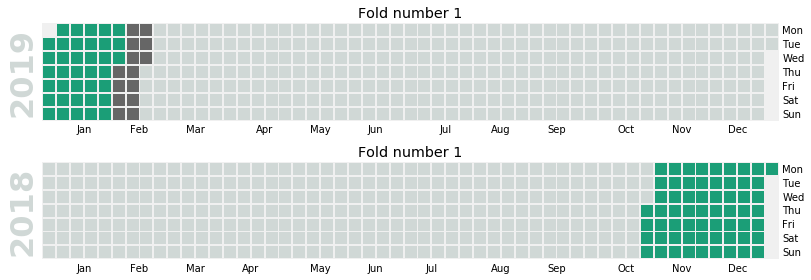

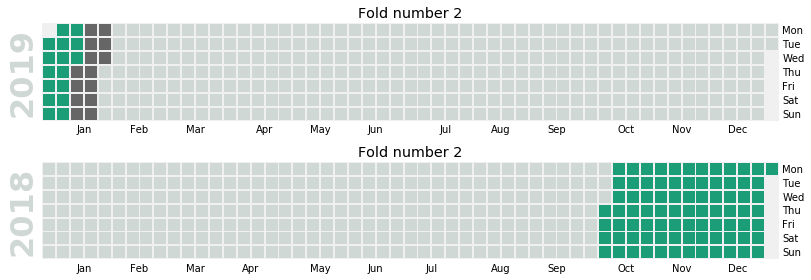

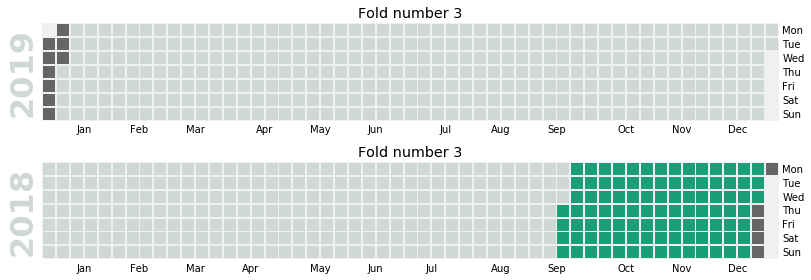

In [24]:
tkf = TimeSeriesKFold(temp_df, date_col='date', n_folds=3, shift=3, test_size=2, train_size=14, verbose=True,
                      visualize=True)
temp_df.drop('date', axis=1, inplace=True)

In [25]:
def get_y(df):
    target_df = df.merge(y_train, on=['pickup_cell', 'created_at'], how='left')
    return target_df.target.fillna(0)

In [26]:
# to keep simularity of close hours  f.e  23: 00  and 01 : 00 are close 
def harmonic_time(value, period=24):
    value *= 2 * np.pi / period
    return [np.cos(value), np.sin(value)]


def add_base_dt_features(df, date_col='created_at'): 
    # add basic datetime features
    
    df['date'] = df[date_col].dt.date
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['week'] = df[date_col].dt.week
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6])
    df['is_friday'] = df['dayofweek'].isin([4])
    df['hour'] = df[date_col].dt.hour 
    df['harmonic_hour_1'], df['harmonic_hour_2'] = zip(*df.apply(lambda row: harmonic_time(row['hour']), axis=1)) 
    df['harmonic_month_1'], df['harmonic_month_2'] = zip(*df.apply(lambda row: harmonic_time(row['hour'], period=12), axis=1))
    return df 

In [27]:
def get_shifted(xtrain, ytrain, shift=1):
    temp_df = xtrain.copy()
    temp_df[f'shifted_y_{shift}'] = ytrain.values
    temp_df = temp_df.sort_values(by=['pickup_cell',  'created_at'])
    pick = temp_df.pickup_cell.values
    date = temp_df.created_at.values
    temp_2 = temp_df.groupby('pickup_cell')[[f'shifted_y_{shift}']].shift(shift)
    temp_2['pickup_cell'] = pick
    temp_2['created_at'] = date
    xtrain = xtrain.merge(temp_2, on=['created_at', 'pickup_cell'], how='left')
    return xtrain

In [28]:
temp_df = add_base_dt_features(temp_df)
temp_df = temp_df.merge(centers, on='pickup_cell', how='left')
temp_df = temp_df.merge(lviv_locations_grouped, on='pickup_cell', how='left')

In [34]:
from sklearn.metrics import mean_squared_error

Training until validation scores don't improve for 50 rounds.
[15]	training's l2: 10.73	valid_1's l2: 5.72624
[30]	training's l2: 6.73493	valid_1's l2: 4.42492
[45]	training's l2: 5.41501	valid_1's l2: 4.13935
[60]	training's l2: 4.90198	valid_1's l2: 4.03082
[75]	training's l2: 4.52042	valid_1's l2: 3.95901
[90]	training's l2: 4.23917	valid_1's l2: 3.95327
[105]	training's l2: 3.98675	valid_1's l2: 3.96666
[120]	training's l2: 3.8075	valid_1's l2: 3.94968
[135]	training's l2: 3.66361	valid_1's l2: 3.94928
[150]	training's l2: 3.5351	valid_1's l2: 3.94553
[165]	training's l2: 3.40554	valid_1's l2: 3.93813
[180]	training's l2: 3.31156	valid_1's l2: 3.92334
[195]	training's l2: 3.23141	valid_1's l2: 3.91274
[210]	training's l2: 3.1532	valid_1's l2: 3.90206
[225]	training's l2: 3.09799	valid_1's l2: 3.89032
[240]	training's l2: 3.02571	valid_1's l2: 3.89244
[255]	training's l2: 2.97784	valid_1's l2: 3.85947
[270]	training's l2: 2.92124	valid_1's l2: 3.83782
[285]	training's l2: 2.85289	va

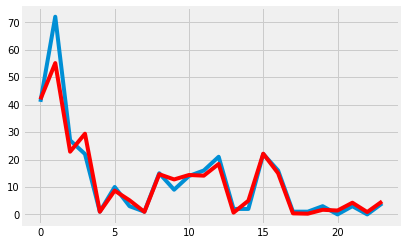

Training until validation scores don't improve for 50 rounds.
[15]	training's l2: 10.6694	valid_1's l2: 8.67629
[30]	training's l2: 6.78422	valid_1's l2: 7.30471
[45]	training's l2: 5.49521	valid_1's l2: 7.06403
[60]	training's l2: 4.92299	valid_1's l2: 6.82437
[75]	training's l2: 4.57857	valid_1's l2: 6.74517
[90]	training's l2: 4.34493	valid_1's l2: 6.45971
[105]	training's l2: 4.08204	valid_1's l2: 6.36558
[120]	training's l2: 3.91287	valid_1's l2: 6.24602
[135]	training's l2: 3.77923	valid_1's l2: 6.22813
[150]	training's l2: 3.63694	valid_1's l2: 6.14711
[165]	training's l2: 3.51736	valid_1's l2: 6.09305
[180]	training's l2: 3.42074	valid_1's l2: 6.12514
[195]	training's l2: 3.34228	valid_1's l2: 6.06666
[210]	training's l2: 3.26398	valid_1's l2: 6.03064
[225]	training's l2: 3.17584	valid_1's l2: 5.98127
[240]	training's l2: 3.10892	valid_1's l2: 6.09348
[255]	training's l2: 3.04409	valid_1's l2: 6.02149
[270]	training's l2: 2.96881	valid_1's l2: 6.03022
Early stopping, best itera

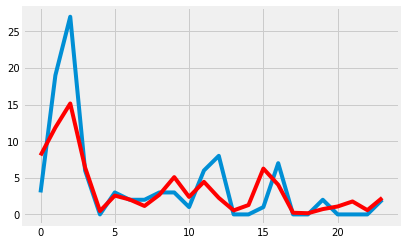

Training until validation scores don't improve for 50 rounds.
[15]	training's l2: 7.67223	valid_1's l2: 23.8139
[30]	training's l2: 4.53076	valid_1's l2: 19.0114
[45]	training's l2: 3.68556	valid_1's l2: 18.5157
[60]	training's l2: 3.32355	valid_1's l2: 18.5703
[75]	training's l2: 3.06255	valid_1's l2: 18.7466
[90]	training's l2: 2.88287	valid_1's l2: 18.9412
Early stopping, best iteration is:
[40]	training's l2: 3.91138	valid_1's l2: 18.4189
MSE: 18.418878516324693


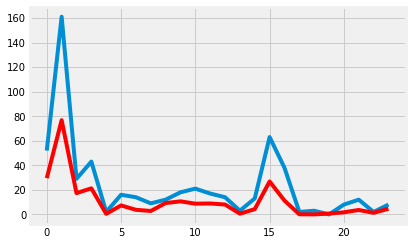

CV MSE mean: 9.332072015366515, std: 6.496571289351842


In [35]:
cv_scores = []

for train_idx, val_idx in tkf:
    xtrain = temp_df.iloc[train_idx]
    xval = temp_df.iloc[val_idx]
    
    ytrain = get_y(xtrain)
    yval = get_y(xval)
    
    
    weights_df = df.groupby(['pickup_cell']).size().reset_index().rename({0: 'weight'}, axis='columns')
    weights_df.weight = weights_df.weight.clip(upper=700, lower=1)
    weights = pd.merge(xtrain, weights_df, on=['pickup_cell']).weight.values
    n_rounds = 10000
    params_lgb = {
    #default
    'objective': 'regression',
    'learning_rates':  0.9,
    'num_threads': 10,
    'n_rounds': 10000, 
    "loss":  ['mse', 'mape'],
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 9, 
    'num_leaves': 32, 
    'min_data_in_leaf' : 17,
    'weight': weights
    }
    cols_to_use = [
    'year', 
    'month', 
    'week',
    'dayofweek',
    'is_weekend', 
    'is_friday', 
    'hour', 
    'harmonic_hour_1',
    'harmonic_hour_2',
    'harmonic_month_1', 
    'harmonic_month_2',
    'cell_center_lat', 
    'cell_center_lng',
    'lviv_locations_amount'
]
    cols_to_use += ["distance_to_adress_{}".format(i) for i in range(len(adresses))]
    cols_to_use += [x for x in xtrain.columns if 'shifted' in x]
    for i in list(range(1, 5)) + [24 * k for k in range(1,3)]:
        xtrain = get_shifted(xtrain, ytrain, i)
        xval = get_shifted(xval, yval, i)
    
    lgbtrain = lgb.Dataset(data=xtrain[cols_to_use],
                           label=ytrain,
                           feature_name=cols_to_use,
                           free_raw_data=False)
    lgbval = lgb.Dataset(data=xval[cols_to_use],
                         label=yval,
                         reference=lgbtrain,
                         feature_name=cols_to_use,
                         free_raw_data=False)
    
    model = lgb.train(params_lgb,
                  lgbtrain,
                  num_boost_round=n_rounds, 
                  valid_sets=[lgbtrain, lgbval], 
                  early_stopping_rounds=50, 
                  verbose_eval=15)
    
    pred_val = model.predict(xval[cols_to_use])
    print("MSE: {}".format(mean_squared_error(yval, pred_val)))
    cv_scores.append(mean_squared_error(yval, pred_val))
    plt.plot(yval.values.astype(np.float64)[:24], label='Actual')
    plt.plot(pred_val[:24], label='Pred', c='r')
    plt.show()
print("CV MSE mean: {}, std: {}".format(np.mean(cv_scores), np.std(cv_scores)))

In [36]:
import shap
shap.initjs()

n = 100
xsample = xtrain.sample(n)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xsample[cols_to_use])


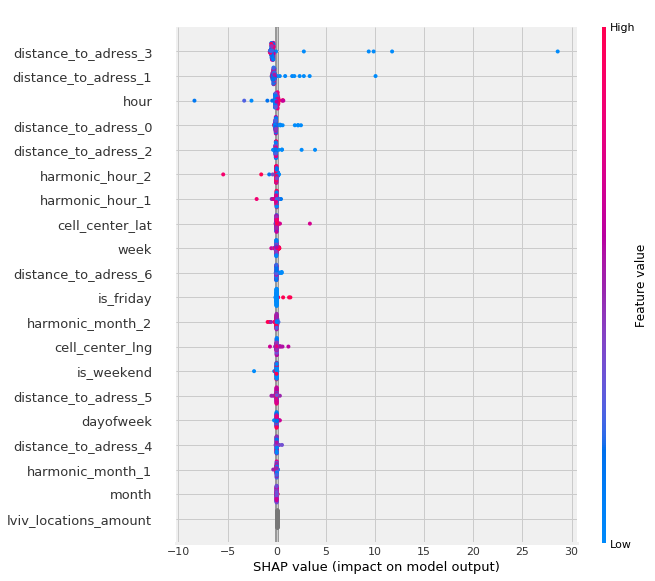

In [37]:
shap.summary_plot(shap_values, xsample[cols_to_use])

# Pipeline (holdout)

In [11]:
df_= df.copy()

In [14]:
df_['date'] = df['created_at'].dt.date

# drop last incomplete  day 
df = df_[df_['date'] != df_['date'].max()]

In [34]:
df['hour'] = df['created_at'].dt.hour 

In [17]:
def split_train_test(df, datetime_col, n_days):
    '''
    Returns train and holdout dataset 
    
    date_col : name of datetime dol

    n_days: size of holdout 
    '''
    
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['date_'] = df[datetime_col].dt.date
    last_day = df['date_'].max()
    start = last_day - relativedelta(days=n_days)
    finish = last_day
    holdout_df = df[(df['date_'] >= start) & (df['date_'] <= finish)]
    train_df = df[(df['date_'] < start)]
    train_df.drop(['date_'], axis='columns', inplace=True)
    holdout_df.drop(['date_'], axis='columns', inplace=True)
    return train_df, holdout_df

def get_y(df):
    target_df = df.merge(y_train, on=['pickup_cell', 'created_at'], how='left')
    return target_df.target.fillna(0)

In [ ]:
# create date + location sceleton 
unified_index = [
    'created_at', 
    'pickup_cell'
]

temp_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [df['created_at'].unique(), 
         df['pickup_cell'].unique()]
    )
).reset_index()

temp_df.columns  = [
    'created_at', 
    'pickup_cell'
]

In [18]:
all_train_df, xtest = split_train_test(temp_df, datetime_col='created_at', n_days=7)

n_weeks = 4   # leave last month for validation 
xtrain, xval = split_train_test(all_train_df, datetime_col='created_at', n_days=7 * n_weeks)


In [20]:
date_col = ['created_at']
print('Train ', xtrain[date_col].min()[0], xtrain[date_col].max()[0])
print('Validation ', xval[date_col].min()[0], xval[date_col].max()[0])
print('holdout ', xtest[date_col].min()[0], xtest[date_col].max()[0])

ytrain = get_y(xtrain)
ytest = get_y(xtest)
yval = get_y(xval)

Train  2018-08-21 00:00:00 2019-01-14 23:00:00
Validation  2019-01-15 00:00:00 2019-02-12 23:00:00
holdout  2019-02-13 00:00:00 2019-02-20 23:00:00


In [ ]:
xtrain = add_base_dt_features(xtrain)
xtest= add_base_dt_features(xtest)
xval = add_base_dt_features(xval)

In [193]:
xtrain = xtrain.merge(centers, on='pickup_cell', how='left')
xtest = xtest.merge(centers, on='pickup_cell', how='left')
xval = xval.merge(centers, on='pickup_cell', how='left')

In [ ]:
xtrain = xtrain.merge(lviv_locations_grouped, on='pickup_cell', how='left')
xtest = xtest.merge(lviv_locations_grouped, on='pickup_cell', how='left')
xval = xval.mergsse(lviv_locations_grouped, on='pickup_cell', how='left')

In [ ]:
def get_shifted(xtrain, ytrain, shift=1):
    temp_df = xtrain.copy()
    temp_df['shifted_y_{}'.format(shift)] = ytrain.values
    temp_df = temp_df.sort_values(by=['pickup_cell',  'created_at'])
    pick = temp_df.pickup_cell.values
    date = temp_df.created_at.values
    temp_2 = temp_df.groupby('pickup_cell')[['shifted_y_{}'.format(shift)]].shift(shift)
    temp_2['pickup_cell'] = pick
    temp_2['created_at'] = date
    xtrain = xtrain.merge(temp_2, on=['created_at', 'pickup_cell'], how='left')
    return xtrain

In [ ]:
for i in list(range(1, 5)) + [24 * k for k in range(1,7)]:
    xtrain = get_shifted(xtrain, ytrain, i)
    xval = get_shifted(xval, yval, i)

In [ ]:
xtrain

In [44]:
cols_to_use = [
#     'date', 
    'year', 
    'month', 
    'week',
    'dayofweek',
    'is_weekend', 
    'is_friday', 
    'hour', 
    'harmonic_hour_1',
    'harmonic_hour_2',
    'harmonic_month_1', 
    'harmonic_month_2',
    'cell_center_lat', 
    'cell_center_lng', 
#     'distance_to_city_center'
]

cols_to_use += ['distance_to_adress_{}'.format(i) for i in range(len(adresses))]
cols_to_use += [x for x in xtrain.columns if 'shifted' in x]

In [46]:
weights_df = df.groupby(['hour', 'pickup_cell']).size().reset_index().rename({0: 'weight'}, axis='columns')
weights_df.weight = weights_df.weight.clip(upper=700, lower=1)

In [36]:
weights = pd.merge(xtrain, weights_df, on=['hour', 'pickup_cell']).weight.values

In [47]:
import lightgbm as lgb 
import xgboost as xgb 

In [51]:
n_rounds = 10000

params_lgb = {
    #default
    'objective': 'regression',
    'learning_rates':  0.9,
    'num_threads': 4,
    'n_rounds': n_rounds, 
    "metric": [
#         'mae', 
        'mse'
    ],
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 9, 
    'num_leaves': 32, 
    'min_data_in_leaf' : 17,
    
#     'weight': weights
    
    
    }



lgbtrain = lgb.Dataset(data=xtrain[cols_to_use], label=ytrain, feature_name=cols_to_use, free_raw_data=False)
lgbval = lgb.Dataset(data=xval[cols_to_use], label=yval, reference=lgbtrain, feature_name=cols_to_use, free_raw_data=False)
# result = lgb.cv(params_lgb, lgb_data, n_rounds, folds=skf, 
#                 early_stopping_rounds=100, verbose_eval=1, ) 

In [52]:
model = lgb.train(params_lgb, lgbtrain, num_boost_round=n_rounds, 
                      valid_sets=[lgbtrain, lgbval], 
          #feval=lgbm_smape, 
                      early_stopping_rounds=50, 
#                       evals_result=evals_result,
          
          verbose_eval=1)

[1]	training's l2: 0.415317	valid_1's l2: 0.356016
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 0.385946	valid_1's l2: 0.327185
[3]	training's l2: 0.362917	valid_1's l2: 0.306908
[4]	training's l2: 0.341651	valid_1's l2: 0.288323
[5]	training's l2: 0.325128	valid_1's l2: 0.273568
[6]	training's l2: 0.311527	valid_1's l2: 0.261655
[7]	training's l2: 0.29972	valid_1's l2: 0.25149
[8]	training's l2: 0.288524	valid_1's l2: 0.241807
[9]	training's l2: 0.279635	valid_1's l2: 0.234983
[10]	training's l2: 0.272692	valid_1's l2: 0.230704
[11]	training's l2: 0.267337	valid_1's l2: 0.227727
[12]	training's l2: 0.260798	valid_1's l2: 0.223222
[13]	training's l2: 0.256227	valid_1's l2: 0.220359
[14]	training's l2: 0.252331	valid_1's l2: 0.218545
[15]	training's l2: 0.249135	valid_1's l2: 0.217033
[16]	training's l2: 0.245554	valid_1's l2: 0.216125
[17]	training's l2: 0.241811	valid_1's l2: 0.214175
[18]	training's l2: 0.239052	valid_1's l2: 0.213324
[19]	training

In [56]:
import shap
shap.initjs()

In [58]:
n = 100
xsample = xtrain.sample(n)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xsample[cols_to_use])


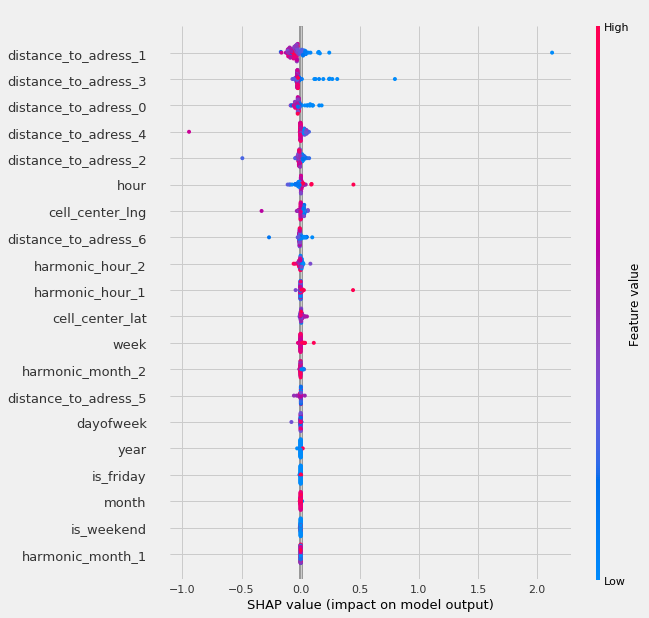

In [61]:
shap.summary_plot(shap_values, xsample[cols_to_use])

# Sarimax


In [ ]:
cv_scores = []

for train_idx, val_idx in tkf:
    xtrain = temp_df.iloc[train_idx]
    xval = temp_df.iloc[val_idx]
    
    ytrain = get_y(xtrain)
    yval = get_y(xval)
    
    sar_m = sarimax.SARIMAX(ytrain.astype(np.float64),
                        trend='n', 
                        order=(2,2,1), 
                        seasonal_order=(0, 2, 2, 24), 
                        simple_differencing=False).fit()
    predict_steps = 24*14
    pred_val = sar_m.forecast(steps=predict_steps)
    
    print("MSE: {}".format(mean_squared_error(yval, pred_val)))
    cv_scores.append(mean_squared_error(yval, pred_val))
    plt.plot(yval.values.astype(np.float64)[:24], label='Actual')
    plt.plot(pred_val[:24], label='Pred', c='r')
    plt.show()
print("CV MSE mean: {}, std: {}".format(np.mean(cv_scores), np.std(cv_scores)))

# TFIDF

In [ ]:
for i in list(range(1, 24*7)):
        xtrain = get_shifted(xtrain, ytrain, i)
        xval = get_shifted(xval, yval, i)

In [ ]:
cols = [x for x in xtrain.columns if 'shifted' in x]
xtrain['string'] = xtrain[cols].apply(lambda x: ' '.join(str(y) for y in x if np.isnull(x).sum() == 0 else ''), 
                                      axis='columns')
xval['string'] = xval[cols].apply(lambda x: ' '.join(str(y) for y in x if np.isnull(x).sum() == 0 else ''), 
                                      axis='columns')

In [ ]:
column = 'string'

train_descriptions = xtrain[column].fillna("none").values.tolist()
test_descriptions = xval[column].fillna("none").values.tolist()

word_vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                                  max_features=20000, 
                                  norm='l2',
                                  token_pattern=r'\w{1,}',
                                  smooth_idf=True,
                                  sublinear_tf=True,
                                  strip_accents='unicode',
                                  min_df=3, max_df=0.95)

char_vectorizer = TfidfVectorizer(sublinear_tf=True,
                                  strip_accents='unicode',
                                  norm = 'l2',
                                  analyzer='char',
                                  ngram_range=(2, 5),
                                  smooth_idf=False,
                                  max_features=50000)

word_vectorizer.fit(train_descriptions + test_descriptions)
char_vectorizer.fit(train_descriptions + test_descriptions)


train_tfidf_features =  word_vectorizer.transform(train_descriptions)
test_tfidf_features =  word_vectorizer.transform(test_descriptions)

size = 10
svd = TruncatedSVD(n_components=size, random_state=1029)
svd.fit(train_tfidf_features)

svd_features_train = svd.transform(train_tfidf_features)
svd_train = pd.DataFrame(svd_features_train, columns=['svd_{}_{}'.format(column, i) for i in range(size)])
xtrain = pd.concat((xtrain, svd_train), axis=1)

svd_features_test = svd.transform(test_tfidf_features)
svd_test = pd.DataFrame(svd_features_test, columns=['svd_{}_{}'.format(column, i) for i in range(size)])
xval = pd.concat((xval, svd_test), axis=1)

nmf = NMF(n_components=size, random_state=1029)
nmf.fit(train_tfidf_features)

nmf_features_train = nmf.transform(train_tfidf_features)
nmf_train = pd.DataFrame(nmf_features_train, columns=['nmf_{}_{}'.format(column, i) for i in range(size)])
xtrain = pd.concat((xtrain, nmf_train), axis=1)

nmf_features_test = nmf.transform(test_tfidf_features)
nmf_test = pd.DataFrame(nmf_features_test, columns=['nmf_{}_{}'.format(column, i) for i in range(size)])
xval = pd.concat((xval, nmf_test), axis=1)